In [ ]:
import pandas as pd

train = pd.read_csv('../data/raq/train.csv')

# 1. 데이터 기본 정보

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter


# 기본 정보
print("🔹 데이터 크기:", train.shape)
print("\n🔹 컬럼명:", train.columns.tolist())
print("\n🔹 라벨 분포:\n", train['generated'].value_counts())
print("\n🔹 결측치:\n", train.isnull().sum())

🔹 데이터 크기: (97172, 3)

🔹 컬럼명: ['title', 'full_text', 'generated']

🔹 라벨 분포:
 generated
0    89177
1     7995
Name: count, dtype: int64

🔹 결측치:
 title        0
full_text    0
generated    0
dtype: int64


# 2. 문장 수 분석
- 각 full_text (문서)의 문장을 ., !, ? 기준으로 나눔
- x축 : 문장 개수
- y축 : 문서 개수

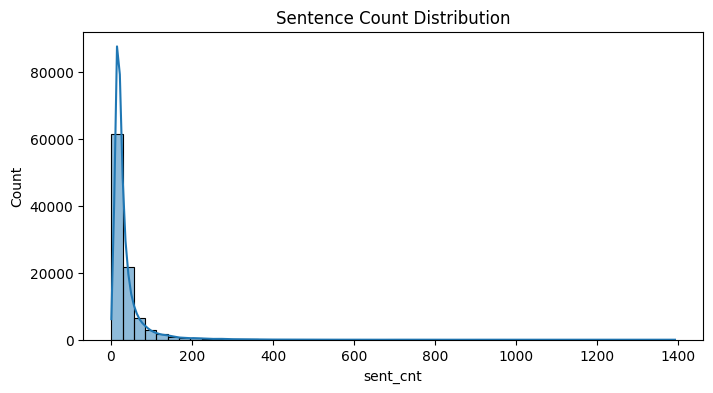

In [ ]:
sentence_split = re.compile(r'[.!?]\s*')
train['sent_cnt'] = train['full_text'].astype(str).apply(lambda x: len(sentence_split.split(x)))

plt.figure(figsize=(8,4))
sns.histplot(train['sent_cnt'], bins=50, kde=True)
plt.title("Sentence Count Distribution")
plt.show()

# 3. 한자, 영어 수

In [ ]:
import re

# 한자 포함 여부
train["has_hanja"] = train["full_text"].apply(lambda x: bool(re.search(r"[一-龥]", str(x))))

# 영문+숫자 포함 여부
train["has_en"] = train["full_text"].apply(lambda x: bool(re.search(r"[a-zA-Z0]", str(x))))

# 라벨별 한자 포함 빈도수
print("🔹 Hanja presence by label")
print(train.groupby('generated')["has_hanja"].value_counts().unstack(fill_value=0))

# 라벨별 영문 포함 빈도수
print("\n🔹 English presence by label")
print(train.groupby('generated')["has_en"].value_counts().unstack(fill_value=0))

🔹 Hanja presence by label
has_hanja  False  True 
generated              
0          53355  35822
1           5452   2543

🔹 English presence by label
has_en     False  True 
generated              
0           4262  84915
1            438   7557


# 4. 괄호 수

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 괄호 개수 컬럼 (이미 있다면 생략 가능)
def count_parentheses(text):
    return text.count('(') + text.count(')')

train['paren_count'] = train['full_text'].astype(str).apply(count_parentheses)

# ✅ 괄호가 있는 문서만 필터링
train_paren = train[train['paren_count'] > 0].copy()

# ✅ 출력: 라벨별 괄호 포함 문서 수 / 비율
summary = (
    train.groupby('generated')['paren_count'].apply(lambda x: (x > 0).sum())
    .to_frame('with_paren_count')
    .reset_index()
)
summary['total'] = train.groupby('generated').size().values
summary['proportion'] = (summary['with_paren_count'] / summary['total'] * 100).round(2)

print("🔹 라벨별 괄호 포함 문서 수 및 비율")
print(summary)



🔹 라벨별 괄호 포함 문서 수 및 비율
   generated  with_paren_count  total  proportion
0          0             80794  89177        90.6
1          1              6548   7995        81.9


# 5. 라벨 별로 문장당 괄호

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ✅ 문장 나누기: . ! ? 뒤 공백 기준
sentence_split = re.compile(r'[.!?]\s*')

def split_sentences(text):
    return sentence_split.split(text)

# ✅ 문장당 괄호 개수 계산 함수
def paren_per_sentence(text):
    sentences = split_sentences(text)
    if len(sentences) == 0:
        return 0
    total_paren = sum(s.count('(') + s.count(')') for s in sentences)
    return total_paren / len(sentences)

# ✅ 문장당 괄호 개수 컬럼 생성
train['paren_per_sent'] = train['full_text'].astype(str).apply(paren_per_sentence)

# ✅ 라벨별 통계 출력
summary = train.groupby('generated')['paren_per_sent'].describe().round(2)
print("🔹 라벨별 문장당 괄호 개수 통계")
print(summary)


🔹 라벨별 문장당 괄호 개수 통계
             count  mean   std  min   25%   50%   75%     max
generated                                                    
0          89177.0  0.58  1.43  0.0  0.14  0.31  0.63  233.00
1           7995.0  0.31  0.50  0.0  0.07  0.17  0.37   12.17


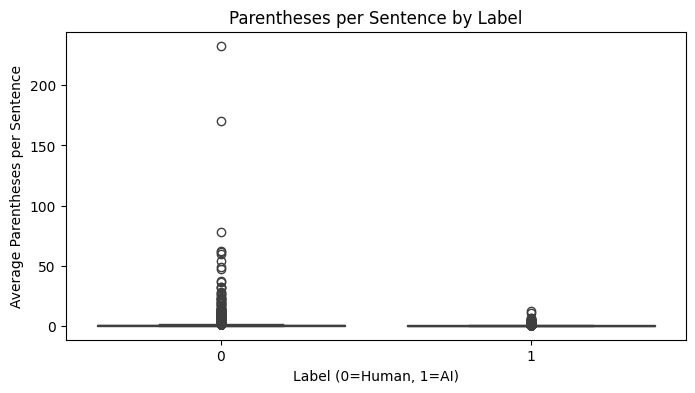

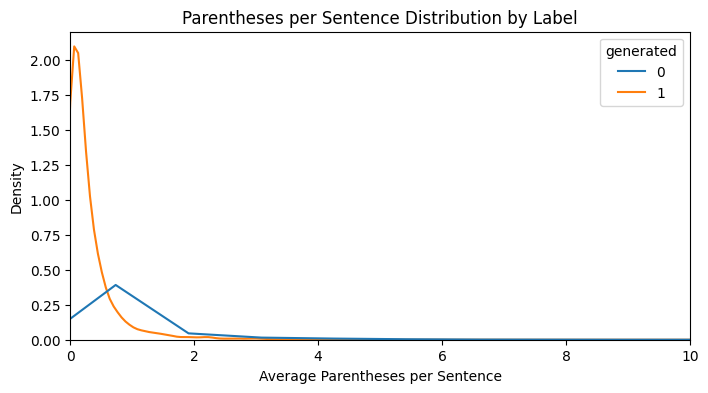

In [ ]:
# ✅ boxplot 시각화
plt.figure(figsize=(8,4))
sns.boxplot(x='generated', y='paren_per_sent', data=train)
plt.title('Parentheses per Sentence by Label')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('Average Parentheses per Sentence')
plt.show()


plt.figure(figsize=(8,4))
sns.kdeplot(
    data=train,
    x='paren_per_sent',
    hue='generated',
    common_norm=False
)
plt.title('Parentheses per Sentence Distribution by Label')
plt.xlabel('Average Parentheses per Sentence')
plt.ylabel('Density')
plt.xlim(0, 10)
plt.show()

*   사람 글은 문장당 괄호 개수가 평균 0.58개로 AI보다 많음
*   사람 글의 표준편차는 1.43으로, 괄호 사용의 변동이 큼
* AI는 괄호 수가 일관적인 편



In [ ]:
# !apt-get install -y mecab libmecab-dev mecab-ipadic-utf8 > /dev/null
# !pip install mecab-python3

In [ ]:
!pip install Korpora
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!ls
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

# 6. 첫문장에 주어 유무

  0%|          | 0/97172 [00:00<?, ?it/s]


🔹 라벨별 첫 문장 주어 없음 비율 (%)
   generated  first_subject_missing
0          0              21.430414
1          1              20.687930


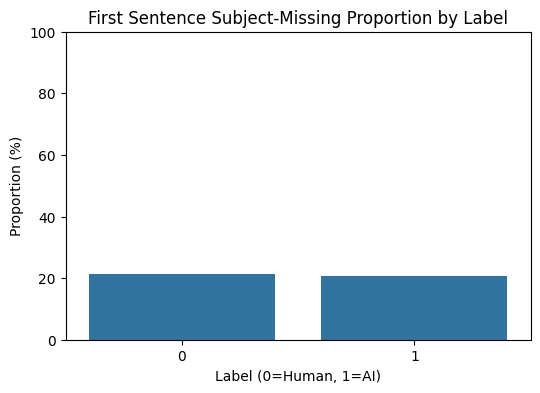

In [ ]:
from konlpy.tag import Mecab
import re
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Mecab 초기화
mecab = Mecab()

# 문장 분리 정규식
sentence_split = re.compile(r'[.!?]\s*')

# 주어 존재 여부 판단 함수
def check_subject_presence(sentence):
    tokens = mecab.pos(sentence)

    noun_block = []
    for word, pos in tokens:
        if pos in ['NNG', 'NNP', 'NP']:
            noun_block.append(word)
        elif pos in ['SSO', 'SSC', 'SN', 'SY', 'NNBC', 'SC', 'SL']:
            continue  # 괄호, 숫자, 쉼표, 한자 무시
        elif pos in ['JKS', 'JX'] and noun_block:
            # 주어 후보 출력 (필요하면 주석 해제)
            # print(f"주어 후보: {' '.join(noun_block)} + {word}({pos})")
            return False  # 주어 있음
        else:
            noun_block = []  # 흐름 깨지면 초기화

    return True  # 주어 못 찾음

# DataFrame에 적용
def apply_first_sentence_subject_check(df, text_col='full_text'):
    tqdm.pandas()

    def get_first_sentence(text):
        sentences = sentence_split.split(str(text))
        if sentences and sentences[0].strip():
            return sentences[0].strip()
        return ""

    df['first_sentence'] = df[text_col].apply(get_first_sentence)
    df['first_subject_missing'] = df['first_sentence'].progress_apply(check_subject_presence)
    return df

# 시각화 및 통계
def plot_subject_missing_stat(df):
    result = df.groupby('generated')['first_subject_missing'].mean().reset_index()
    result['first_subject_missing'] = result['first_subject_missing'] * 100

    print("\n🔹 라벨별 첫 문장 주어 없음 비율 (%)")
    print(result)

    plt.figure(figsize=(6,4))
    sns.barplot(data=result, x='generated', y='first_subject_missing')
    plt.title('First Sentence Subject-Missing Proportion by Label')
    plt.xlabel('Label (0=Human, 1=AI)')
    plt.ylabel('Proportion (%)')
    plt.ylim(0, 100)
    plt.show()

# === 사용 방법 ===
train = apply_first_sentence_subject_check(train)
plot_subject_missing_stat(train)

의미가 없었다.. 인간이 쓴것도 주어없는거 있더라

- 교위, 전수대부(한나라 식으로는 남양태수)를 역임했으며, 녹림군의 장군 유인과 싸워 패사했다. 전한 평제
시기, 흉노가 전한 서역도호부에 원한을 품고 투항한 거사후왕과 거호래왕을 돌려보내도록 명하는 사절단에서 중랑장 한륭(韓隆)·왕창(王昌) 다음 부교위로 참여했다. 이후 전한과 흉노가 계속 교섭하여 중국인·오손인·중국의 인수를 받은 서역인·오환인이 흉노에 투항하면

# 7. 쉼표 개수

🔹 라벨별 문장당 쉼표 개수 통계
             count  mean   std  min   25%   50%   75%     max
generated                                                    
0          89177.0  0.72  1.11  0.0  0.42  0.63  0.89  255.50
1           7995.0  0.41  0.35  0.0  0.20  0.34  0.53    9.67


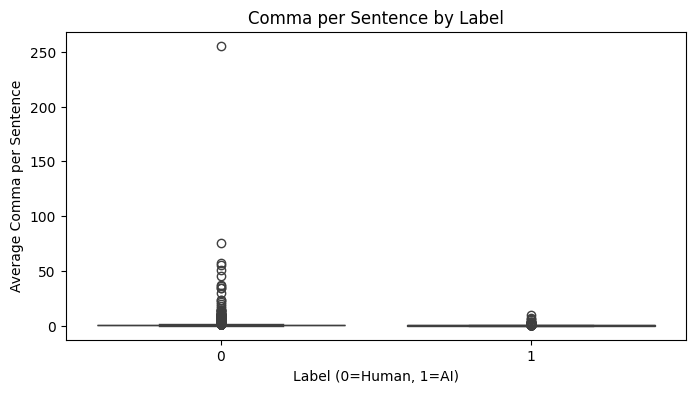

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 문장 나누기: . ! ? 뒤 공백 기준
sentence_split = re.compile(r'[.!?]\s*')

def split_sentences(text):
    return sentence_split.split(text)

# 문장당 쉼표 개수 계산 함수
def comma_per_sentence(text):
    sentences = split_sentences(text)
    if len(sentences) == 0:
        return 0
    total_comma = sum(s.count(',') for s in sentences)
    return total_comma / len(sentences)

# 문장당 쉼표 개수 컬럼 생성
train['comma_per_sent'] = train['full_text'].astype(str).apply(comma_per_sentence)

# 라벨별 통계 출력
summary = train.groupby('generated')['comma_per_sent'].describe().round(2)
print("🔹 라벨별 문장당 쉼표 개수 통계")
print(summary)

# 시각화 (선택)
plt.figure(figsize=(8,4))
sns.boxplot(data=train, x='generated', y='comma_per_sent')
plt.title('Comma per Sentence by Label')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('Average Comma per Sentence')
plt.show()

# 8. (, 가 있는거

🔹 라벨별 ( 쉼표 시작 패턴 개수 통계
             count  mean   std  min  25%  50%  75%   max
generated                                               
0          89177.0  0.15  0.46  0.0  0.0  0.0  0.0  31.0
1           7995.0  0.08  0.30  0.0  0.0  0.0  0.0   4.0


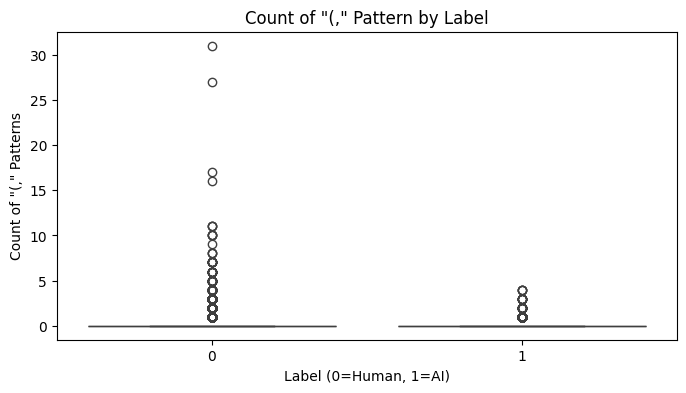

In [ ]:
import re

# 괄호 열고 쉼표로 시작하는 패턴 탐지
def paren_comma_start_count(text):
    # \(, 또는 ( , 패턴 탐지
    matches = re.findall(r'\(\s*,', text)
    return len(matches)

# 컬럼 생성
train['paren_comma_start'] = train['full_text'].astype(str).apply(paren_comma_start_count)

# 라벨별 통계 출력
summary = train.groupby('generated')['paren_comma_start'].describe().round(2)
print("🔹 라벨별 ( 쉼표 시작 패턴 개수 통계")
print(summary)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.boxplot(data=train, x='generated', y='paren_comma_start')
plt.title('Count of "(," Pattern by Label')
plt.xlabel('Label (0=Human, 1=AI)')
plt.ylabel('Count of "(," Patterns')
plt.show()

In [ ]:
import re

# ( 쉼표로 시작하는 괄호 패턴 탐지 함수
def paren_comma_start_count(text):
    return len(re.findall(r'\(\s*,', text))

# 컬럼 생성
train['paren_comma_start'] = train['full_text'].astype(str).apply(paren_comma_start_count)

# ( 쉼표 시작 패턴이 1개 이상 있는 행의 인덱스 추출
pattern_indices = train[train['paren_comma_start'] > 0].index.tolist()

# 결과 출력
print(f"🔹 '(,' 패턴이 포함된 문서 수: {len(pattern_indices)}")
print(f"🔹 해당 인덱스 (상위 10개): {pattern_indices[:10]}")

🔹 '(,' 패턴이 포함된 문서 수: 12635
🔹 해당 인덱스 (상위 10개): [3, 6, 39, 44, 45, 46, 49, 68, 83, 89]


In [ ]:
from konlpy.tag import Mecab

# Mecab 초기화
mecab = Mecab()

def print_mecab_tokens(sentence):
    tokens = mecab.pos(sentence)
    print(f"🔹 입력 문장: {sentence}")
    print("🔹 Mecab 토큰 분석 결과:")
    for word, pos in tokens:
        print(f"  ({word}, {pos})")

# ✅ 테스트 문장
text = "천문학에서 청색거성(靑色巨星, )은 광도 분류에서 III형(거성) 또는 II형(밝은 거성)인 뜨거운 별이다."
print_mecab_tokens(text)

🔹 입력 문장: 천문학에서 청색거성(靑色巨星, )은 광도 분류에서 III형(거성) 또는 II형(밝은 거성)인 뜨거운 별이다.
🔹 Mecab 토큰 분석 결과:
  (천문학, NNG)
  (에서, JKB)
  (청색, NNG)
  (거성, NNG)
  ((, SSO)
  (靑色, NNG)
  (巨星, NNG)
  (,, SC)
  (), SSC)
  (은, JX)
  (광도, NNG)
  (분류, NNG)
  (에서, JKB)
  (III, SL)
  (형, XSN)
  ((, SSO)
  (거성, NNG)
  (), SSC)
  (또는, MAJ)
  (II, SL)
  (형, XSN)
  ((, SSO)
  (밝, VA)
  (은, ETM)
  (거성, NNG)
  (), SSC)
  (인, VCP+ETM)
  (뜨거운, VA+ETM)
  (별, NNG)
  (이, VCP)
  (다, EF)
  (., SF)


In [ ]:
from konlpy.tag import Mecab
import pandas as pd
import re
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Mecab 초기화
mecab = Mecab()

# 문장 분리 정규식
sentence_split = re.compile(r'[.!?]\s*')

def check_subject_presence(sentence):
    tokens = mecab.pos(sentence)

    noun_block = []
    for word, pos in tokens:
        if pos in ['NNG', 'NNP', 'NP']:
            noun_block.append(word)
        elif pos in ['SSO', 'SSC', 'SN', 'SY', 'NNBC', 'SC', 'SL']:
            continue  # 괄호, 숫자, 쉼표, 한자 무시
        elif pos in ['JKS', 'JX'] and noun_block:
            print(f"주어 후보: {' '.join(noun_block)} + {word}({pos})")
            return False  # 주어 있음
        else:
            noun_block = []  # 흐름 깨지면 초기화

    return True  # 주어 못 찾음

In [ ]:
text = "부교위, 전수대부(한나라 식으로는 남양태수)를 역임했으며, 녹림군의 장군 유인과 싸워 패사했다."
result = check_subject_presence(text)
print(result)

주어가 없습니다
